# IMPORTING LIBRARIES

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
from multiprocessing import Process
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2


import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

In [2]:
from zipfile import ZipFile
import os
def get_all_files(directory): #function to get all files from directory
    paths = []
    for root, dirs, files in os.walk(directory):
              for f_name in files:
                    path = os.path.join(root, f_name) #get a file and add the total path
                    paths.append(path)
    return paths #Return the file paths
directory = 'C:\MINE\DATA SCIENCE\my datasets\SPOT MASK'
paths = get_all_files(directory)
paths

['C:\\MINE\\DATA SCIENCE\\my datasets\\SPOT MASK\\images.zip',
 'C:\\MINE\\DATA SCIENCE\\my datasets\\SPOT MASK\\sample_sub_v2.csv',
 'C:\\MINE\\DATA SCIENCE\\my datasets\\SPOT MASK\\train_labels.csv']

# UNZIP IMAGES ZIP FILE AND DATA DIVISION

In [3]:
PATH = \
{
    "" : "",
    "CSV" : os.path.join( "SPOT MASK", "CSV",  ),
    "IMAGES" : os.path.join( "SPOT MASK", "IMAGES",  ),
    "garbage" : os.path.join( "SPOT MASK", "IMAGES", "images"  ),
    "train" : os.path.join( "SPOT MASK", "IMAGES", "train" ),
    "test" : os.path.join( "SPOT MASK", "IMAGES", "test" ),
    "garbage_df" : os.path.join( "SPOT MASK", 'train_labels.csv' ),
    "zip_imgs" : os.path.join( "SPOT MASK", 'images.zip' )
}

In [4]:
def unzip():
    print('unzip file')
    with ZipFile('C:\\MINE\\DATA SCIENCE\\my datasets\\SPOT MASK\\images.zip', 'r') as zf:
       #display the files inside the zip
    #    zf.printdir()
       #Extracting the files from zip file
        zf.extractall(path=PATH['IMAGES'],)
    print('zip completed')

In [5]:
def dataset():

    unzip()

    total_imgs = len(os.listdir( PATH['garbage'] ))
    print(f"[INFO] {total_imgs} images in garbage folder 'images' ")

    garbage_df = pd.read_csv( PATH["garbage_df"] )
    print(f"[INFO] {garbage_df.shape[0]} images in df ")


    print(f"[INFO] Creating folders to arrange train images by label ")
    mask_folder = os.path.join(PATH['train'], "1-MASK")
    no_mask_folder = os.path.join(PATH['train'], "0-NO_MASK")

    os.makedirs(name=mask_folder , exist_ok=True)
    os.makedirs(name=no_mask_folder , exist_ok=True)

    no_mask_filenames = garbage_df[garbage_df.target == 0].image.tolist()
    mask_filenames = garbage_df[garbage_df.target == 1].image.tolist()

    # Parallel moving
    print(f"[INFO] Moving NO_MASK images ")
    _ = []
    for name in no_mask_filenames:
        try:
            p = Process( target=shutil.move, args=(os.path.join( PATH['garbage'],name ), no_mask_folder))
            p.start()
            _ += [p]
        except:
            pass
    
    print(f"[INFO] Moving MASK images ")
    for name in mask_filenames:
        try:
            p = Process( target=shutil.move, args=(os.path.join( PATH['garbage'],name ), mask_folder))
            p.start()
            _ += [p]
        except:
            pass
    [p.join() for p in _]

    print(f"[INFO] Rename garbage folder : 'images' --> 'test'")
    os.rename( PATH['garbage'], PATH['test'],  )

    check = total_imgs == (garbage_df.shape[0] + len(os.listdir(PATH['test'])))
    if check:
        print(f"[INFO] Succesful processing")
        print(f"[INFO] {len(os.listdir(mask_folder))} images in folder '{mask_folder}' ")
        print(f"[INFO] {len(os.listdir(no_mask_folder))} images in folder '{no_mask_folder}' ")
        print(f"[INFO] {len(os.listdir(PATH['test']))} images in folder '{PATH['test']}'.")
    else:
        shutil.rmtree(PATH['IMAGES'])
        os.makedirs(PATH['IMAGES'], exist_ok=True)

        print(f"[INFO] Processing failed, re-run this function please.")


In [6]:
dataset()

unzip file
zip completed
[INFO] 1817 images in garbage folder 'images' 
[INFO] 1308 images in df 
[INFO] Creating folders to arrange train images by label 
[INFO] Moving NO_MASK images 
[INFO] Moving MASK images 
[INFO] Rename garbage folder : 'images' --> 'test'
[INFO] Succesful processing
[INFO] 644 images in folder 'SPOT MASK\IMAGES\train\1-MASK' 
[INFO] 664 images in folder 'SPOT MASK\IMAGES\train\0-NO_MASK' 
[INFO] 509 images in folder 'SPOT MASK\IMAGES\test'.


 # DATA PREPROCESSING

In [7]:
images=[]
size=(224,224)

def Get_dataset():
    data=[]
    for root,_,file in tqdm(os.walk(PATH['IMAGES'])):
        for name in file:
            file_path=os.path.join(root,name)
            target = os.path.split(root)[-1]
            img = cv2.imread(os.path.join(root,name))
            im = cv2.resize(img,size)
            images.append(im)

            
            data+=[{"file path":file_path,"target":target}]
    return pd.DataFrame(data)

In [8]:
global_data=Get_dataset()

In [9]:
global_data.shape

(1817, 2)

In [10]:
global_data.head(10)

,file path,target
0,SPOT MASK\IMAGES\test\aadawlxbmapqrblgxyzarhja...,test
1,SPOT MASK\IMAGES\test\abpxvdfyhaaohzcrngcucmhf...,test
2,SPOT MASK\IMAGES\test\aclkjfvackiieiznzfcwienp...,test
3,SPOT MASK\IMAGES\test\aelkivmayxgsdjosiibfgmkv...,test
4,SPOT MASK\IMAGES\test\aelzzshpfxerelefnkatpczk...,test
5,SPOT MASK\IMAGES\test\ajnjnkvstqesvfohaptobyas...,test
6,SPOT MASK\IMAGES\test\akkydnvilgvzigllmboonbqb...,test
7,SPOT MASK\IMAGES\test\akvjfjhgayyjwrqrczjbeyoq...,test
8,SPOT MASK\IMAGES\test\alcveyvosnywyjbmngolmnbl...,test
9,SPOT MASK\IMAGES\test\alfuzzlrjkdrrzauiswqnuvp...,test


In [11]:
test_df=pd.DataFrame.where(global_data[['file path']],global_data['target']=='test')
test_df=test_df.dropna()

test_df

,file path
0,SPOT MASK\IMAGES\test\aadawlxbmapqrblgxyzarhja...
1,SPOT MASK\IMAGES\test\abpxvdfyhaaohzcrngcucmhf...
2,SPOT MASK\IMAGES\test\aclkjfvackiieiznzfcwienp...
3,SPOT MASK\IMAGES\test\aelkivmayxgsdjosiibfgmkv...
4,SPOT MASK\IMAGES\test\aelzzshpfxerelefnkatpczk...
...,...
504,SPOT MASK\IMAGES\test\zpfhbgixcctxylnihhrepjgc...
505,SPOT MASK\IMAGES\test\zuignwckjykxefmpubjpjefv...
506,SPOT MASK\IMAGES\test\zuxvwdblfwjpibjexgfglpyr...
507,SPOT MASK\IMAGES\test\zvyajojutzgqumdjfxxkpiuu...


In [12]:
train_df=global_data.drop(test_df.index)

# to shuffle the data
train_df=train_df.sample(frac=1)
train_df

,file path,target
565,SPOT MASK\IMAGES\train\0-NO_MASK\cfyvfdnelarfy...,0-NO_MASK
1160,SPOT MASK\IMAGES\train\0-NO_MASK\zppvqmcinubiv...,0-NO_MASK
1508,SPOT MASK\IMAGES\train\1-MASK\lzeoocbmavdnknwk...,1-MASK
1597,SPOT MASK\IMAGES\train\1-MASK\qapxcqfrgijwglgl...,1-MASK
944,SPOT MASK\IMAGES\train\0-NO_MASK\rcxywpuskfedm...,0-NO_MASK
...,...,...
634,SPOT MASK\IMAGES\train\0-NO_MASK\fdmqoopxbplrq...,0-NO_MASK
698,SPOT MASK\IMAGES\train\0-NO_MASK\hqeofiflkshpm...,0-NO_MASK
1552,SPOT MASK\IMAGES\train\1-MASK\nwbfhzwpelzlcvrx...,1-MASK
877,SPOT MASK\IMAGES\train\0-NO_MASK\owuysehbrtkkr...,0-NO_MASK


# IMAGES VISUALIZATION

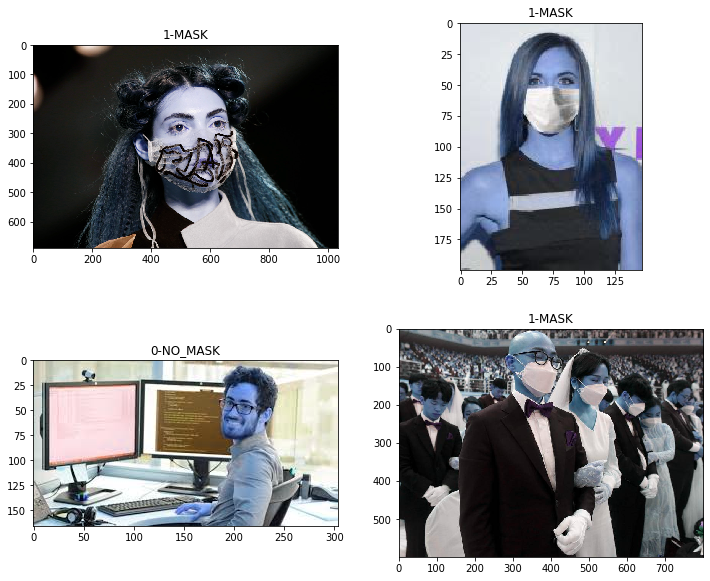

In [13]:

plt.figure(figsize=(12,10))

for i in range (1,5):
    
    img=cv2.imread(np.array(train_df['file path'][1:6])[i])
    ax=plt.subplot(2, 2,i)
    plt.imshow(img)
    plt.title(np.array(train_df['target'][1:6])[i])
    
plt.show()

# DATASET SPLIT

In [14]:
classes = train_df.target.unique().tolist()
classes

['0-NO_MASK', '1-MASK']

In [15]:
train_df=train_df.sample(frac=1)
train_df

,file path,target
757,SPOT MASK\IMAGES\train\0-NO_MASK\jsioghmkkmygq...,0-NO_MASK
1398,SPOT MASK\IMAGES\train\1-MASK\idzcsuscitfkvavp...,1-MASK
1078,SPOT MASK\IMAGES\train\0-NO_MASK\wqocnoddovces...,0-NO_MASK
1617,SPOT MASK\IMAGES\train\1-MASK\rehiddykktnnhwzu...,1-MASK
1739,SPOT MASK\IMAGES\train\1-MASK\wfgjfivjkiitifof...,1-MASK
...,...,...
1205,SPOT MASK\IMAGES\train\1-MASK\bakyihlfeuqedfia...,1-MASK
675,SPOT MASK\IMAGES\train\0-NO_MASK\gvuvnlfasuyym...,0-NO_MASK
1337,SPOT MASK\IMAGES\train\1-MASK\fqkgmohcyrwitouf...,1-MASK
1744,SPOT MASK\IMAGES\train\1-MASK\wrgixgvogbvrvrvs...,1-MASK


In [16]:

# splitting the train images into train and validation images.

train_data, eval_data = train_test_split(train_df, test_size=0.3, random_state=42)
train_data = train_data.reset_index(drop=True)
eval_data = eval_data.reset_index(drop=True)

# DATA AUGMENTATION

In [17]:
INIT_LR=1e-4
EPOCHS=30
BS=32


# initialize an our data augmenter as an "empty" image data generator
train_datagen = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
    
eval_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_dataframe(train_data, x_col='file path', y_col='target',target_size=size,
                                                  classes=classes, class_mode='categorical',shuffle=True,batch_size=BS,)

eval_generator=eval_datagen.flow_from_dataframe(eval_data, x_col='file path', y_col='target',target_size=size,
                                                 classes=classes,class_mode='categorical',shuffle=False,batch_size=BS,)




Found 915 validated image filenames belonging to 2 classes.
Found 393 validated image filenames belonging to 2 classes.


# TRANSFORMED IMAGES VISUALIZATION

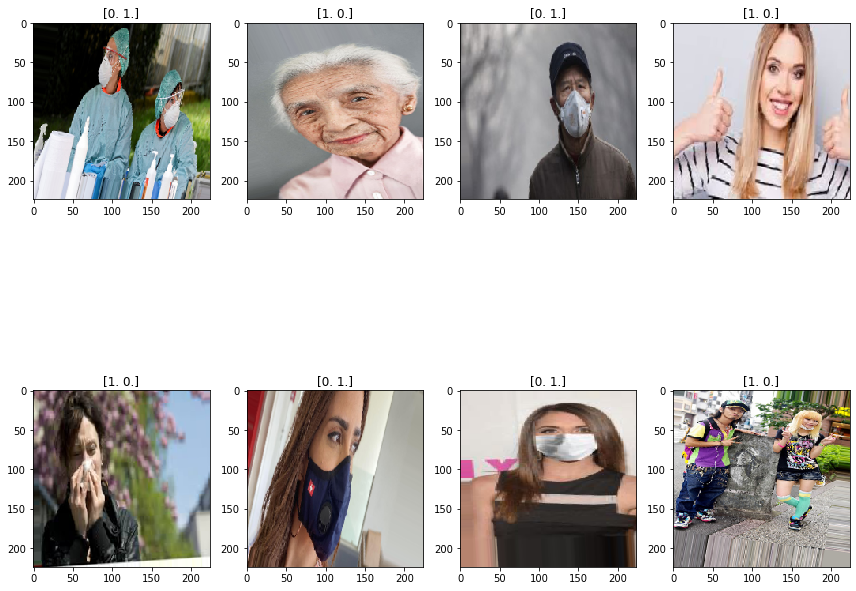

In [18]:

plt.figure(figsize=(12, 12))
for i in range(0, 8):
    plt.subplot(2, 4, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[3]
        plt.imshow(image)
        plt.title(Y_batch[3])
        break
plt.tight_layout()
plt.show()

# TRANSFER LEARNING

In [19]:
input_tensor = Input(shape=(224, 224, 3))
lastModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=input_tensor)

FirstModel = lastModel.output
FirstModel = AveragePooling2D(pool_size=(2, 2))(FirstModel)
FirstModel = Dropout(0.4)(FirstModel)
FirstModel = BatchNormalization()(FirstModel)
FirstModel = Flatten(name="flatten")(FirstModel)
FirstModel = Dense(1000, activation="relu")(FirstModel)
FirstModel = Dropout(0.5)(FirstModel)
FirstModel = Dense(2, activation="softmax")(FirstModel)

model = Model(inputs=lastModel.input, outputs=FirstModel)
                   


for layer in lastModel.layers:
    layer.trainable = False

#  compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])


#  train the head of the network
print("[INFO] training head...")
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=eval_generator.n//eval_generator.batch_size


H = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=eval_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,verbose=2)
H

[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
28/28 - 47s - loss: 0.6840 - accuracy: 0.7610 - val_loss: 0.3740 - val_accuracy: 0.9036
Epoch 2/30
28/28 - 48s - loss: 0.3233 - accuracy: 0.8856 - val_loss: 0.3121 - val_accuracy: 0.9167
Epoch 3/30
28/28 - 47s - loss: 0.3244 - accuracy: 0.8879 - val_loss: 0.2520 - val_accuracy: 0.9297
Epoch 4/30
28/28 - 47s - loss: 0.2656 - accuracy: 0.9128 - val_loss: 0.2756 - val_accuracy: 0.9323
Epoch 5/30
28/28 - 55s - loss: 0.2764 - accuracy: 0.9128 - val_loss: 0.2234 - val_accuracy: 0.9375
Epoch 6/30
28/28 - 55s - loss: 0.2553 - accuracy: 0.9003 - val_loss: 0.2283 - val_accuracy: 0.9375
Epoch 7/30
28/28 - 51s - loss: 0.2035 - accuracy: 0.9253 - val_loss: 0.2451 - val_accuracy: 0.9297
Epoch 8/30
28/28 - 55s - loss: 0.1638 - accuracy: 0.9354 - val_loss: 0.2301 - val_accuracy: 0.9297
Epoch 9/30
28/28 - 55s - loss: 0.1661 - accuracy: 0.9456 - val_loss: 0.2340 - val_

# MODEL PERFORMANCE VISUALIZATION

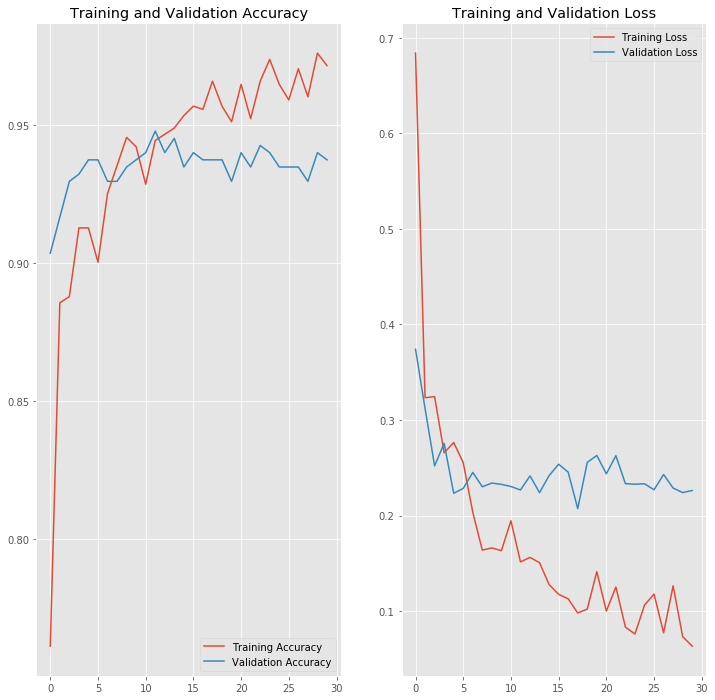

<Figure size 432x288 with 0 Axes>

In [20]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']

loss=H.history['loss']
val_loss=H.history['val_loss']

epochs_range = range(EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('Spotmaskplot.png')

In [21]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('spot_mask_detector.model', save_format="h5")

[INFO] saving mask detector model...


# WORKING ON THE TEST DATASET TO MAKE A SUBMISSION

In [22]:
test_df

,file path
0,SPOT MASK\IMAGES\test\aadawlxbmapqrblgxyzarhja...
1,SPOT MASK\IMAGES\test\abpxvdfyhaaohzcrngcucmhf...
2,SPOT MASK\IMAGES\test\aclkjfvackiieiznzfcwienp...
3,SPOT MASK\IMAGES\test\aelkivmayxgsdjosiibfgmkv...
4,SPOT MASK\IMAGES\test\aelzzshpfxerelefnkatpczk...
...,...
504,SPOT MASK\IMAGES\test\zpfhbgixcctxylnihhrepjgc...
505,SPOT MASK\IMAGES\test\zuignwckjykxefmpubjpjefv...
506,SPOT MASK\IMAGES\test\zuxvwdblfwjpibjexgfglpyr...
507,SPOT MASK\IMAGES\test\zvyajojutzgqumdjfxxkpiuu...


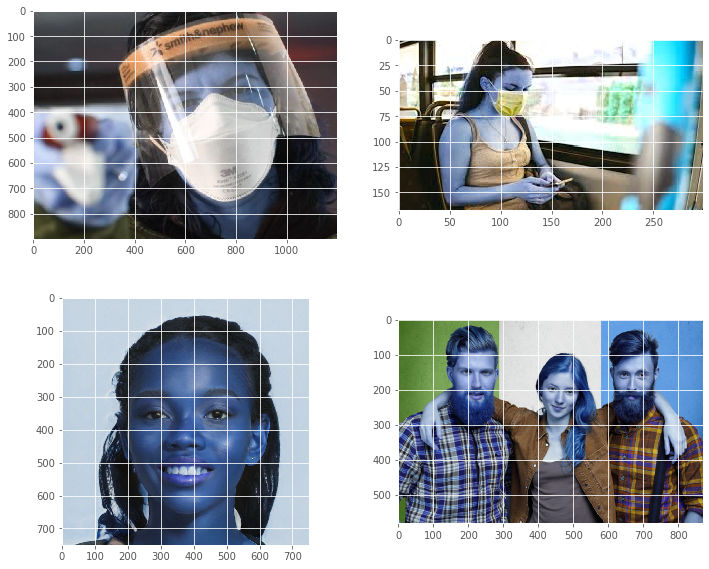

In [23]:
# visualize images from test dataset

plt.figure(figsize=(12,10))

for i in range (1,5):
    
    img=cv2.imread(np.array(test_df['file path'][1:6])[i])
    ax=plt.subplot(2, 2,i)
    plt.imshow(img)

plt.show()

In [24]:
# Data generation on the test dataset
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    x_col='file path',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BS,
    shuffle=False
)

Found 509 validated image filenames.


In [25]:
predictions = model.predict(test_generator, steps=np.ceil(test_df.shape[0]/BS))

In [26]:
test_df['target']=predictions[:,1]

In [27]:
images_name=[]
for i in range(len(test_df)):
    imgs=test_df['file path'][i].split('\\')[-1]
    images_name.append(imgs)
test_df['image']=images_name

In [28]:
test_df=test_df[['image','target']]
sub=test_df.copy()
sub.to_csv('subbmission.csv',index=False)